# Introduction

## Motivation

This work assumes that a linear model, built using regression of some kind, is appropriate to map wiki hits to disease incidence. We have three reasons to make this assumption:

1. Prior work using such a model gets decent results.
2. There is lots of expertise readily available on linear regression.
3. Python has mature, off-the-shelf tools to do such regression that fit our pipeline (we use scikit-learn).

Relaxation of this assumption is out of scope for the time being. In particular, non-linear models may be better; that's future work.

Our goals are:

1. Make good forecasts.
2. Pick articles that are contextually relevant, i.e., avoid Google's high school basketball problem without manual intervention.

Linear models are good at the first, and our hope is that they can do the second well enough for this work to make a useful contribution, with future work swapping in something more principled.

After making this assumption, several questions remain. The purpose of this notebook is to prototype these choices. This is not an exhaustive study; we use US influenza with 2 years of training as a test case.

## Questions

In this section, we outline the questions we need to ask as well the reasoning for what a principled choice might be. Below, we compare these principled choices with results on prototype data.

### Q1. Which regression algorithm?

We consider:

1. Ordinary least squares — minimize model fit error only.
2. Ridge regression — minimize fit error as well as coefficient magnitude, with the weight of the latter tunable with parameter 𝛼.
3. Lasso regression — minimize fit error as well as the number of non-zero coefficients, the latter again tunable with 𝛼.
4. Elastic net — minimize all three of fit error, coefficient magnitude, and non-zero coefficient count. The total weight of both regularization terms is tuned with 𝛼, and their relative weight is tuned with 𝜌 ∈ [0,1].

We want the ridge penalty because we have lots of correlated input groups, and we want the coefficients of each article in a group to be roughly equal.

We want the lasso penalty in order to produce simpler models and because we want a way to exclude bogus articles from the model.

Principled choice: **elastic net** seems the most appropriate, since both the ridge and lasso penalties are desirable, and it incorporates both.

### Q2. Normalize article time series?

Article hit rates vary by several orders of magnitude. Normalization scales the time series to be more similar. scikit-learn uses the L2 norm, transforming vectors into the unit vector.

Principled choice: **Normalize** because it reduces model risk due to these varying hit rates.

### Q3. Restrict coefficients to be positive?

Some algorithms let you require coefficients to be positive (really, non-negative).

Principled choice: **Positive**. It's hard to think of relevant articles that are negatively correlated with a disease, and it's easy to think of spurious ones, for example, for flu, anything that goes up in the summer.

### Q4. Select 𝛼 manually or automatically?

Principled choice: **Automatically**, because more knobs are a hassle.

𝛼 in particular seems hard to choose manually, since it's continuous and has an infinite range.

### Q5. Select 𝜌 manually or automatically?

Principled choice: **Automatically**, because more knobs are a hassle.

However, 𝜌 is easier to choose manually since its range is limited and there are some obvious values to try (e.g., ½).

## Conclusions

### Summary table

| Algorithm | Normalized | Positive | Auto—𝛼 | Auto-𝜌 || Predictions | Articles | Principled | More? |
|-----------|:----------:|:--------:|:------:|:------:||:--------:|:--------:|:----------:|:-:|
|           |            |          |        |        ||          |          |            |
| OLS       | norm       | —        | —      | —      || bad      | bad?     | 1/2        |
|           | non-norm   | —        | —      | —      || bad      | unknown  | 0/2        |
|           |            |          |        |        ||          |          |            |
| Ridge     | norm       | —        | auto   | —      || bad      | bad?     | 2/3
|           | norm       | —        | man    | —      || bad      | unknown  | 1/3
|           | non-norm   | —        | auto   | —      || medium   | unknown  | 1/3
|           | non-norm   | —        | man    | —      || medium   | unknown  | 0/3
|           |            |          |        |        ||          |          |            |
| Lasso     | norm       | pos      | auto   | —      || good     | medium?  | 3/4 | yes
|           | norm       | pos      | man    | —      || good     | medium?  | 2/4
|           | norm       | +/–      | auto   | —      || good     | medium   | 2/4
|           | norm       | +/–      | man    | —      || good     | bad?     | 1/4
|           | non-norm   | pos      | auto   | —      || good     | bad?     | 2/4
|           | non-norm   | pos      | man    | —      || good     | good     | 1/4
|           | non-norm   | +/–      | auto   | —      || medium   | bad      | 1/4
|           | non-norm   | +/–      | man    | —      || good     | bad?     | 0/4
|           |            |          |        |        ||          |          |            |
|Elastic Net| norm       | pos      | auto   | auto   || good     | good?    | 5/5 | yes
|           | norm       | pos      | auto   | man    || good     | good     | 4/5 | yes
|           | norm       | +/–      | auto   | auto   || good     | medium   | 4/5
|           | norm       | +/–      | auto   | man    || good     | good?    | 3/5
|           | non-norm   | pos      | auto   | auto   || medium   | bad?     | 4/5
|           | non-norm   | pos      | auto   | man    || good     | bad?     | 3/5
|           | non-norm   | +/–      | auto   | auto   || bad      | bad      | 3/5
|           | non-norm   | +/–      | auto   | man    || bad      | bad?  | 2/5

The above table summarizes our results. *Principled* refers to the number of questions (0—5) to which the answer matches the principled choice.

### General observations

1. Informally, the *Predictions* and *Articles* results are somewhat unstable. Specifically, during the repair of two bugs that added more articles to the data set (one where articles with spaces were excluded, and another where the link gathering technique was improved), the values in these columns changed significantly, though generally for the better. This suggests that the regression algorithms' ability to select relevant articles is limited.

2. Many options produce good predictions. This is good, because it means that prediction quality is not too sensitive to the algorithm, so further adjustment to optimize article choices and principledness is practical. 

### Questions

1. **Which algorithm?** Both elastic net and lasso turned in generally good prediction, particularly in the more principled configurations, with variable article selection quality.
2. **Normalize article time series?** Prediction quality is generally better in a normalized configuration vs. an otherwise identical non-normalized configuration. Additionally, normalized is the more principled option. 
3. **Positive-only coefficients?** Prediction quality is generally better in the positive-only configurations vs. otherwise-identical unrestricted, and prediction noise seems to be lower. Positive is also more principled.
4. **Auto-𝛼?** Prediction quality doesn't really point one way or the other. However, due to the huge range of 𝛼, it seems unworkable to select a single value, and automatic is the more principled choice.
5. **Auto-𝜌?** Prediction quality doesn't really point one way or the other. Also, manual selection seems feasible since the range is [0,1].

### What's next?

The indicated rows will be considered further in `category_distance.ipynb`. Specifically, we'll try a better article selection procedure to improve the ratio of relevant to non-relevant articles.

# Preamble

## Imports

The IPython Notebook server must be run with environment variable `WEIRD_AL_YANKOVIC` set to the directory containing the paper's auxiliary data.

In [1]:
%matplotlib inline

import gzip
import pickle
import os

import numpy as np
import matplotlib as plt
import pandas as pd
import sklearn as sk
import sklearn.linear_model

data_path = os.environ['WEIRD_AL_YANKOVIC']
plt.rcParams['figure.figsize'] = (12, 4)

## Load and preprocess data

Load the truth spreadsheet.

In [2]:
truth = pd.read_excel(data_path + '/truth.xlsx', index_col=0)
truth = truth.loc[:,'us+influenza']  # pull Series
truth.index = truth.index.to_period('W-SAT')
truth.head()

start
2010-07-04/2010-07-10    0.941927
2010-07-11/2010-07-17    0.880415
2010-07-18/2010-07-24    0.842615
2010-07-25/2010-07-31    0.858382
2010-08-01/2010-08-07    0.833830
Freq: W-SAT, Name: us+influenza, dtype: float64

Load the Wikipedia link data.

In [3]:
relevant = pickle.load(gzip.open(data_path + '/articles/wiki-graph.pkl.gz'))
relevant = relevant['en+Influenza']
relevant = { u.replace('%20', '_') for u in relevant }  # doesn't canonicalize percent-encoding

Load all the time series and filter down to those that are linked from "en/Influenza".

Units: Fraction of total English traffic, e.g. 0.01 means 1% of total traffic to English language articles went to the article in question.

In [4]:
ts_all = pd.read_csv(data_path + '/tsv/forecasting_W-SAT.norm.tsv',
                     sep='\t', index_col=0, parse_dates=True)
ts_all.index = ts_all.index.to_period('W-SAT')
ts_all.rename(columns=lambda x: x[:-5], inplace=True)
len(ts_all.columns)

4179

In [5]:
ts_all.iloc[:,:2].head()

,ar+%D8%A2%D9%81%D8%A9,ar+%D8%A3%D8%A8%D9%88_%D8%A8%D9%83%D8%B1_%D8%A7%D9%84%D8%B1%D8%A7%D8%B2%D9%8A
2007-11-25/2007-12-01,NaN,NaN
2007-12-02/2007-12-08,NaN,NaN
2007-12-09/2007-12-15,0,0.000306
2007-12-16/2007-12-22,0,0.000170
2007-12-23/2007-12-29,0,0.000192


In [6]:
ts_all = ts_all.filter(items=relevant)
ts_all.iloc[:,:5].head()

,en+Hemopneumothorax,en+PubMed,en+Epiglottitis,en+Measles,en+Hepatitis_B
2007-11-25/2007-12-01,NaN,NaN,NaN,NaN,NaN
2007-12-02/2007-12-08,NaN,NaN,NaN,NaN,NaN
2007-12-09/2007-12-15,3.641000e-07,0.000002,0.000001,0.000015,0.000017
2007-12-16/2007-12-22,3.648000e-07,0.000002,0.000001,0.000017,0.000014
2007-12-23/2007-12-29,3.528000e-07,0.000002,0.000001,0.000016,0.000013


In [7]:
len(ts_all.columns)

571

## Join and clean data

Align the time series so that they are the same length and have the same dates.

In [8]:
(ts_all, truth) = ts_all.align(truth, axis=0, join='inner')

Plot ground truth data (US ILI).

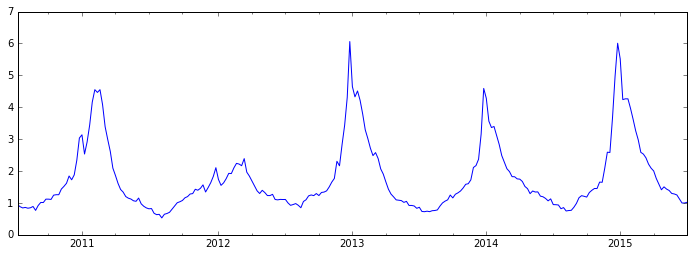

In [9]:
truth.plot()

Plot a few arbitrary article time series. The Y axis is fraction of total English traffic.

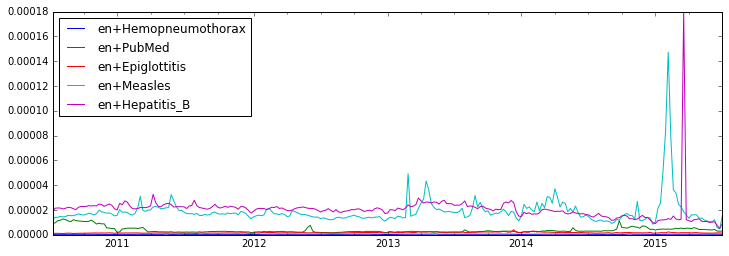

In [10]:
ts_all.iloc[:,:5].plot()

Replace any NaNs with zero. This should largely be a no-op, since normalization in `timeseries.py` takes care of this when normalizing against language totals.

In [11]:
def tidy(df):
   df.fillna(0, inplace=True)

tidy(ts_all)
tidy(truth)

Remove time series that are more than 1/3 zero.

In [12]:
keep_cols = ts_all.astype(bool).sum() > 2/3 * len(ts_all)
ts_all.drop(ts_all.columns[~keep_cols], axis=1, inplace=True)
ts_all.iloc[:,:5].head()

,en+Hemopneumothorax,en+PubMed,en+Epiglottitis,en+Measles,en+Hepatitis_B
2010-07-04/2010-07-10,2.626000e-07,0.000009,0.000001,0.000012,0.000019
2010-07-11/2010-07-17,3.746000e-07,0.000010,0.000001,0.000014,0.000021
2010-07-18/2010-07-24,3.722000e-07,0.000011,0.000001,0.000014,0.000022
2010-07-25/2010-07-31,3.596000e-07,0.000012,0.000001,0.000015,0.000022
2010-08-01/2010-08-07,3.578000e-07,0.000013,0.000001,0.000014,0.000021


In [13]:
len(ts_all.columns)

543

## Define fit function

This function is the core of the prototype. It fits a nowcasting model against the training period, then plots the model predictions against ground truth.

In [14]:
def fit(alg, train_week_ct, ts_all, truth):
   ts_train = ts_all.iloc[:train_week_ct,:]
   truth_train = truth.iloc[:train_week_ct]
   m = alg.fit(ts_train, truth_train)
   pred = m.predict(ts_all)
   # this is just a line to show how long the training period is
   train_period = truth.iloc[:train_week_ct].copy(True)
   train_period[:] = 0
   pd.DataFrame({'truth':       truth,
                 'prediction':  pred,
                 'training pd': train_period}).plot(ylim=(-1,9))
   sumry = pd.DataFrame({'coefs': m.coef_,
                         'coefs_abs': np.abs(m.coef_)},
                        index=ts_all.columns)
   sumry.sort_values(by='coefs_abs', ascending=False, inplace=True)
   sumry = sumry.loc[:, 'coefs']
   for a in ('intercept_', 'alpha_', 'l1_ratio_'):
      try:
         sumry = pd.Series([getattr(m, a)], index=[a]).append(sumry)
      except AttributeError:
         pass
   return (m, sumry)

# Parameter sweep

We now explore the effect of different parameters on the sample data. We are looking for two things:

1. **Are the nowcasts good?**
   * Does the general shape of the prediction match the truth?
   * Does the peak have correct timing?
   * Is there any over- or under-shoot of the peak?
   * Is the 1st season post-training better than the 2nd and 3rd?
   * Are errors tidy or wild?
2. **Are the selected articles reasonable?**
   * Are they related to flu?
   * Is the number of non-zero coefficients not too high and not to low?

The latter question is complicated because coefficients aren't interpretable, since they are affected by the magnitude of the input series. That is, if one article's coefficient is twice that of another, we can't conclude the first is twice as important because it might have fewer (or more) hits. Thus, we can only judge coefficients on whether they are zero or not.

Define ranges for automatic 𝛼 and 𝜌

In [15]:
ALPHAS = np.logspace(-15, 2, 25)
RHOS = np.linspace(0.1, 0.9, 9)

## Ordinary least squares

OLS has an additional problem in that if the number of articles is greater than the number of training examples, which is the case here, then the training data will always get an exact fit.

### OLS, normalized

* Forecast: bad (overfit)
* Articles: bad?

intercept_                                       1.660947
en+Xavier_Saelens                          2861555.317409
en+Human_metapneumovirus                   1388122.752674
en+National_Influenza_Centers              1335872.368334
en+Host_%28biology%29                     -1287146.802329
en+Endemic_%28epidemiology%29              1268200.668675
en+James_Robins                            1146078.965454
en+Rapid_influenza_diagnostic_test         1140833.707306
en+Walter_Fiers                            1138247.780017
en+Influenza_virus_nucleoprotein           1036712.583261
en+Global_spread_of_H5N1_in_2004           1017446.745062
en+Specialty_%28medicine%29                 988486.965613
en+Pulmonary_talcosis                      -878468.078167
en+Molecular_virology                       864087.768161
en+Immunity_%28medical%29                   857068.456510
en+Central_nervous_system_viral_disease    -805780.862590
en+Global_spread_of_H5N1_in_2005            665567.754531
en+Herpesviral

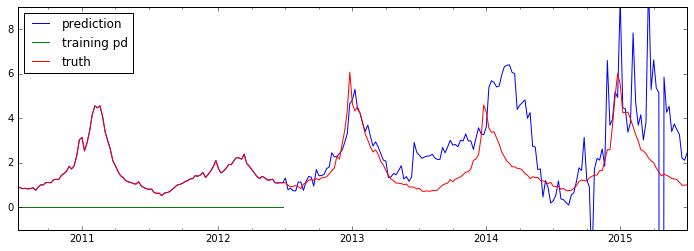

In [16]:
(m, s) = fit(sk.linear_model.LinearRegression(normalize=True),
             104, ts_all, truth)
s.head(21)

### OLS, not normalized

* Forecast: bad
* Articles: unknown

intercept_                                     1.264551
en+Human_respiratory_syncytial_virus       68113.019530
en+Influenza_A_virus                       54144.205819
en+Influenzavirus_B                        45385.815620
en+Influenza                               43542.674371
en+Diarrhea                               -39624.136356
en+Fever                                   39364.835413
en+Pharyngitis                             35101.183609
en+PubMed                                 -34347.517533
en+Oseltamivir                             34116.806593
en+Nasal_septum_deviation                 -32320.539819
en+Influenza_A_virus_subtype_H3N2         -30347.721858
en+Croup                                   30041.812294
en+Epithelium                              30020.747807
en+Proton                                  28289.150944
en+Guillain%E2%80%93Barr%C3%A9_syndrome   -27433.533640
en+Herpes_simplex_virus                   -27382.616443
en+Influenza_A_virus_subtype_H1N1          26777

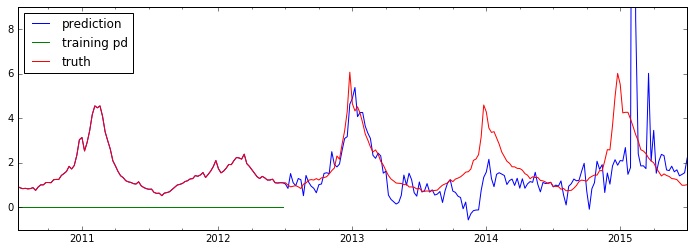

In [17]:
(m, s) = fit(sk.linear_model.LinearRegression(normalize=False),
             104, ts_all, truth)
s.head(21)

## Ridge regression

If 𝛼 is too small, the prediction is nearly constant.

### Ridge, normalized, auto 𝛼

* Forecast: bad (overfit, decays to OLS)
* Articles: bad?

alpha_                                     5.108970e-15
intercept_                                 1.725927e+00
en+Xavier_Saelens                          2.716245e+06
en+National_Influenza_Centers              1.347704e+06
en+Host_%28biology%29                     -1.286538e+06
en+Endemic_%28epidemiology%29              1.254435e+06
en+Global_spread_of_H5N1_in_2004           1.209799e+06
en+Human_metapneumovirus                   1.180775e+06
en+James_Robins                            1.174187e+06
en+Walter_Fiers                            1.172023e+06
en+Rapid_influenza_diagnostic_test         1.168551e+06
en+Influenza_virus_nucleoprotein           1.021397e+06
en+Immunity_%28medical%29                  9.257935e+05
en+Specialty_%28medicine%29                9.084004e+05
en+Pulmonary_talcosis                     -8.531552e+05
en+Richard_Shope                           8.296110e+05
en+Central_nervous_system_viral_disease   -7.795096e+05
en+Molecular_virology                      7.209

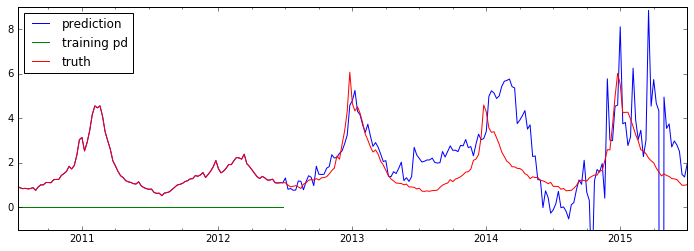

In [18]:
(m, s) = fit(sk.linear_model.RidgeCV(normalize=True, alphas=ALPHAS),
             104, ts_all, truth)
s.head(22)

### Ridge, normalized, manual 𝛼

* Forecast: bad
* Articles: unknown

intercept_                                       1.599466
en+Xavier_Saelens                          1904554.164497
en+Global_spread_of_H5N1_in_2004           1338251.017424
en+Human_metapneumovirus                   1212483.759813
en+Endemic_%28epidemiology%29              1171451.001843
en+Rapid_influenza_diagnostic_test         1155536.918201
en+James_Robins                             917746.730376
en+Influenza_virus_nucleoprotein            896271.247958
en+Host_%28biology%29                      -841481.337487
en+Walter_Fiers                             782589.307085
en+Immunity_%28medical%29                   717234.399001
en+Central_nervous_system_viral_disease    -642276.132087
en+Sense_%28molecular_biology%29            623367.485945
en+Pulmonary_talcosis                      -554534.123978
en+Influenzavirus_C                         529986.956986
en+Follicular_dendritic_cell_sarcoma       -509944.814031
en+National_Influenza_Centers               486129.862930
en+Global_spre

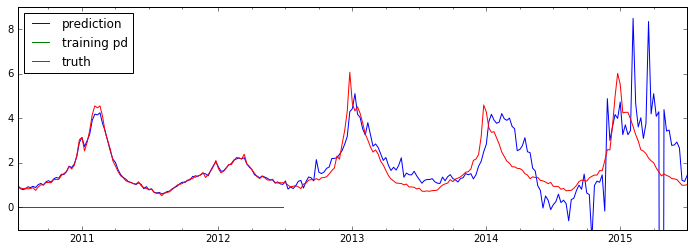

In [19]:
(m, s) = fit(sk.linear_model.Ridge(normalize=True, alpha=1),
             104, ts_all, truth)
s.head(21)

### Ridge, non-normalized, auto 𝛼

* Forecast: medium
* Articles: unknown

alpha_                                     1.000000e-15
intercept_                                 1.267609e+00
en+Human_respiratory_syncytial_virus       6.813026e+04
en+Influenza_A_virus                       5.416390e+04
en+Influenzavirus_B                        4.538250e+04
en+Influenza                               4.356708e+04
en+Diarrhea                               -3.969015e+04
en+Fever                                   3.935326e+04
en+Pharyngitis                             3.513586e+04
en+PubMed                                 -3.434298e+04
en+Oseltamivir                             3.411818e+04
en+Nasal_septum_deviation                 -3.231839e+04
en+Influenza_A_virus_subtype_H3N2         -3.034732e+04
en+Croup                                   3.003976e+04
en+Epithelium                              2.998333e+04
en+Proton                                  2.824782e+04
en+Guillain%E2%80%93Barr%C3%A9_syndrome   -2.742327e+04
en+Herpes_simplex_virus                   -2.742

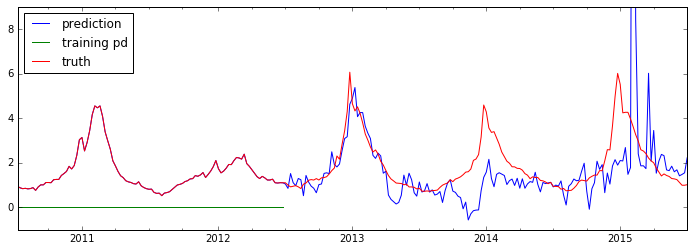

In [20]:
(m, s) = fit(sk.linear_model.RidgeCV(normalize=False, alphas=ALPHAS),
             104, ts_all, truth)
s.head(22)

### Ridge, non-normalized, manual 𝛼

* Forecast: medium
* Articles: unknown

intercept_                                  1.388426
en+Influenza                            34714.830941
en+Human_respiratory_syncytial_virus    22418.298859
en+Influenza_A_virus                    20354.930621
en+Bronchitis                           20178.735713
en+Gross_domestic_product               17930.694325
en+Influenzavirus_B                     15062.582284
en+Fever                                14391.551059
en+Recession                           -12727.978857
en+Influenza_A_virus_subtype_H1N1       11713.809110
en+Oseltamivir                          11003.369019
en+Pneumonia                            10598.833517
en+Evolution                            10347.530549
en+Norovirus                             9835.378495
en+Pancreatitis                         -9691.198591
en+Human_papillomavirus                  9657.938890
en+Pharyngitis                           9340.017644
en+Diarrhea                             -9075.101872
en+Liver                                -9071.

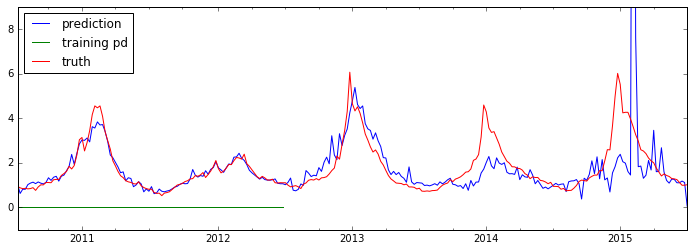

In [21]:
(m, s) = fit(sk.linear_model.Ridge(normalize=False, alpha=1e-9),
             104, ts_all, truth)
s.head(21)

## Lasso

### Lasso, normalized, positive, auto 𝛼

* Forecast: good
* Articles: medium?

alpha_                                       0.005623
intercept_                                   0.022746
en+Influenzavirus_B                     306033.201426
en+Oseltamivir                          250061.452733
en+Astrovirus                           192171.192388
en+Human_respiratory_syncytial_virus     96977.479536
en+Bronchiolitis                         60478.064236
en+Croup                                  4355.457743
en+Laryngitis                             1306.756835
en+Frank_Macfarlane_Burnet                   0.000000
en+Ghent_University                          0.000000
en+Pneumomediastinum                         0.000000
en+2009_flu_pandemic                         0.000000
en+Hemagglutinin                             0.000000
en+Hemopneumothorax                          0.000000
en+Wendell_Meredith_Stanley                  0.000000
en+Specialty_%28medicine%29                  0.000000
en+Pneumonitis                               0.000000
en+Pathogenesis             

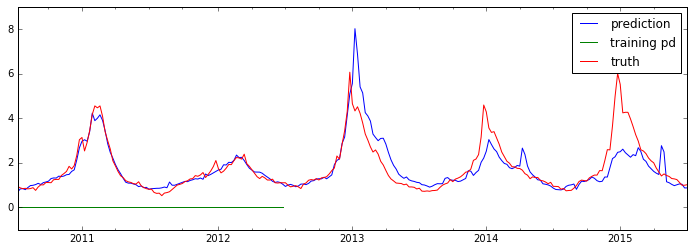

In [22]:
(m, s) = fit(sk.linear_model.LassoCV(normalize=True, positive=True,
                                     alphas=ALPHAS, max_iter=20000),
             104, ts_all, truth)
s.head(22)

### Lasso, normalized, positive, manual 𝛼

* Forecast: good
* Articles: medium?

intercept_                                     -1.239008
en+Patrick_Laidlaw                        6218331.612971
en+Immunity_%28medical%29                 2368163.717335
en+Richard_Shope                          1595053.552230
en+Influenza_A_virus_subtype_H3N8         1363544.068307
en+Walter_Fiers                            735441.672765
en+Influenzavirus_B                        392666.508779
en+2007_Bernard_Matthews_H5N1_outbreak     300601.594014
en+James_Robins                            274639.034074
en+Fujian_flu                              191645.573603
en+Ramsay_Hunt_syndrome_type_II            139678.482347
en+Oseltamivir                             126969.860842
en+Human_respiratory_syncytial_virus       113765.026293
en+Mumps_virus                             104718.713197
en+Equine_influenza                         81605.130950
en+Culling                                  70916.621093
en+Influenza_treatment                      68769.717018
en+Chalicosis                  

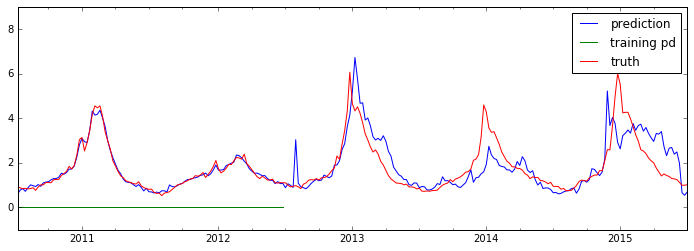

In [23]:
(m, s) = fit(sk.linear_model.Lasso(normalize=True, positive=True,
                                   alpha=1e-3),
             104, ts_all, truth)
s.head(21)

### Lasso, normalized, unrestricted, auto 𝛼

* Forecast: good
* Articles: medium

alpha_                                       0.005623
intercept_                                   0.178157
en+Influenzavirus_B                     309190.876821
en+Oseltamivir                          247859.406960
en+Pneumomediastinum                   -241133.337987
en+Astrovirus                           121122.469304
en+Human_respiratory_syncytial_virus     91212.054757
en+Bronchiolitis                         74378.827740
en+Croup                                  9112.124564
en+Specialty_%28medicine%29                 -0.000000
en+2009_flu_pandemic                        -0.000000
en+Hemagglutinin                             0.000000
en+Frank_Macfarlane_Burnet                   0.000000
en+Wendell_Meredith_Stanley                 -0.000000
en+Hemopneumothorax                         -0.000000
en+Recession                                -0.000000
en+Pneumonitis                              -0.000000
en+Pathogenesis                             -0.000000
en+Restrictive_lung_disease 

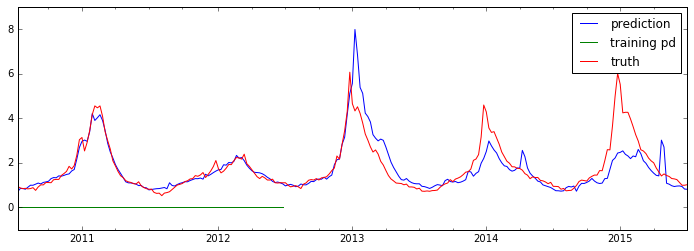

In [24]:
(m, s) = fit(sk.linear_model.LassoCV(normalize=True, alphas=ALPHAS,
                                     max_iter=20000),
             104, ts_all, truth)
s.head(22)

### Lasso, normalized, unrestricted, manual 𝛼

* Forecast: good
* Articles: bad?

intercept_                                      1.752455
en+Central_nervous_system_viral_disease   -908597.366347
en+Walter_Fiers                            667720.075330
en+Immunity_%28medical%29                  649409.609485
en+Pneumomediastinum                      -588170.851473
en+BK_virus                               -464633.072887
en+Chandipura_virus                       -366806.967713
en+Patrick_Laidlaw                         326667.243584
en+Influenzavirus_B                        291817.724063
en+Penile_cancer                          -275935.477542
en+Oseltamivir                             273333.388448
en+Global_spread_of_H5N1_in_2007           259742.410783
en+James_Robins                            231820.802099
en+Influenza_prevention                   -230575.419799
en+Human_parainfluenza_viruses             180279.261298
en+Influenza_treatment                     145659.360897
en+Myelitis                               -100039.047059
en+Influenza-like_illness      

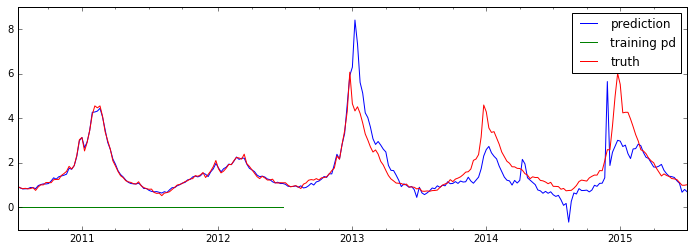

In [25]:
(m, s) = fit(sk.linear_model.Lasso(normalize=True, alpha=1e-3),
                                   104, ts_all, truth)
s.head(21)

### Lasso, non-normalized, positive, auto 𝛼

* Forecast: good
* Articles: bad?

alpha_                                  2.371374e-09
intercept_                             -1.946009e+00
en+Influenzavirus_B                     3.950839e+05
en+Oseltamivir                          1.471980e+05
en+Influenza_treatment                  1.156963e+05
en+Human_respiratory_syncytial_virus    1.046554e+05
en+Sore_throat                          8.606633e+04
en+Influenza_A_virus_subtype_H5N1       5.554838e+04
en+Pleural_empyema                      4.481064e+04
en+Allergic_rhinitis                    3.905720e+04
en+Anal_cancer                          3.649644e+04
en+Croup                                3.597195e+04
en+Nasal_septum_perforation             2.868253e+04
en+Ramsay_Hunt_syndrome_type_II         2.629343e+04
en+Wayback_Machine                      1.709160e+04
en+United_States_Army                   1.680341e+04
en+Bibcode                              1.666415e+04
en+Epstein%E2%80%93Barr_virus           1.337207e+04
en+Pharyngitis                          1.1871

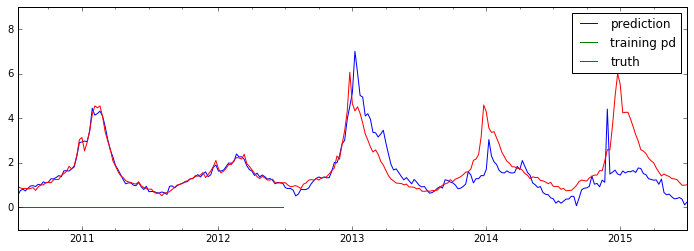

In [26]:
(m, s) = fit(sk.linear_model.LassoCV(normalize=False, positive=True,
                                     alphas=ALPHAS, max_iter=20000),
             104, ts_all, truth)
s.head(22)

### Lasso, non-normalized, positive, manual 𝛼

* Forecast: good
* Articles: good

intercept_                                   -0.150126
en+Human_respiratory_syncytial_virus     178426.645274
en+Influenzavirus_B                      105094.484150
en+Influenza_A_virus                      93267.932249
en+Influenza                              17379.110153
en+Bronchitis                             13085.440811
en+HIV                                     2535.662165
en+International_Standard_Book_Number       413.524053
en+Cat                                      267.016702
en+Specialty_%28medicine%29                   0.000000
en+2009_flu_pandemic                          0.000000
en+Hemagglutinin                              0.000000
en+Frank_Macfarlane_Burnet                    0.000000
en+Wendell_Meredith_Stanley                   0.000000
en+Canine_influenza                           0.000000
en+Pneumonitis                                0.000000
en+Peramivir                                  0.000000
en+Ghent_University                           0.000000
en+Pathoge

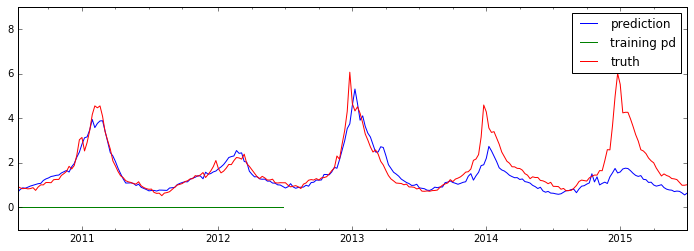

In [27]:
(m, s) = fit(sk.linear_model.Lasso(normalize=False, positive=True,
                                   alpha=1e-7),
             104, ts_all, truth)
s.head(21)

### Lasso, non-normalized, unrestricted, auto 𝛼

* Forecast: medium
* Articles: bad

alpha_                                               0.000002
intercept_                                          -0.130553
en+Influenza                                     53561.317826
en+Pneumonia                                     15125.606525
en+Christopher_Columbus                          -2206.646976
en+International_Standard_Book_Number               56.098039
en+Hemopneumothorax                                 -0.000000
en+Hemagglutinin                                    -0.000000
en+Cytoplasm                                        -0.000000
en+Recession                                        -0.000000
en+Ghent_University                                  0.000000
en+Pneumomediastinum                                -0.000000
en+2009_flu_pandemic                                -0.000000
en+Wendell_Meredith_Stanley                          0.000000
en+Frank_Macfarlane_Burnet                           0.000000
en+Prevalence                                       -0.000000
en+Speci

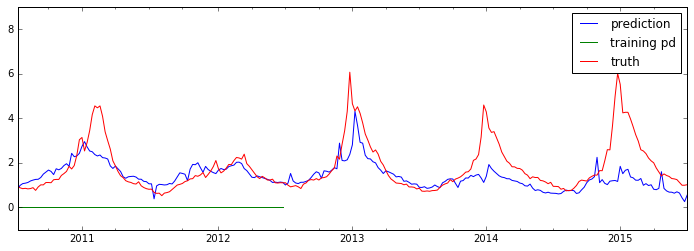

In [28]:
(m, s) = fit(sk.linear_model.LassoCV(normalize=False, alphas=ALPHAS,
                                     max_iter=20000),
             104, ts_all, truth)
s.head(22)

### Lasso, non-normalized, unrestricted, manual 𝛼

* Forecast: good
* Articles: bad?

intercept_                                    0.998470
en+Human_respiratory_syncytial_virus     167224.029975
en+Influenza_A_virus                      90728.285106
en+Influenza                              64446.625191
en+Diabetes_mellitus                     -11907.673137
en+Epidemiology                           -9040.196092
en+1918_flu_pandemic                      -8179.001298
en+Recession                              -6491.326805
en+United_States_dollar                   -6216.443819
en+New_England                            -5538.067194
en+HIV                                     4993.687837
en+Protein                                -4265.548460
en+Dog                                    -4088.371717
en+Cancer                                 -3824.088188
en+Cell_nucleus                           -3073.065884
en+Hepatitis_C                            -2882.243708
en+Poultry                                -2655.011191
en+Swine_influenza                        -1625.337739
en+United_

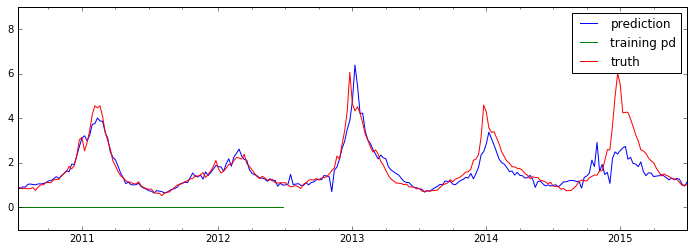

In [29]:
(m, s) = fit(sk.linear_model.Lasso(normalize=False, alpha=1e-7),
             104, ts_all, truth)
s.head(21)

## Elastic net

Note: of the 16 possible elastic net variations, we tried only 8, since the other 8 (manual 𝛼) seemed unlikely to win.

### Elastic net, normalized, positive, auto 𝛼, auto 𝜌

* Forecast: good
* Articles: good?

l1_ratio_                                    0.900000
alpha_                                       0.005623
intercept_                                  -0.068701
en+Influenzavirus_C                     515821.358356
en+Influenzavirus_B                     258037.263919
en+Oseltamivir                          221442.677680
en+Human_respiratory_syncytial_virus     93797.753125
en+Astrovirus                            71697.363269
en+Bronchiolitis                         69920.107771
en+Viral_encephalitis                    23124.828198
en+Influenza_A_virus                     20145.626667
en+Influenza_treatment                    4994.547033
en+Laryngitis                             4385.475699
en+Influenza                              2770.980382
en+Croup                                   526.554603
en+Bronchitis                              167.628505
en+Pneumonitis                               0.000000
en+Wendell_Meredith_Stanley                  0.000000
en+Specialty_%28medicine%29 

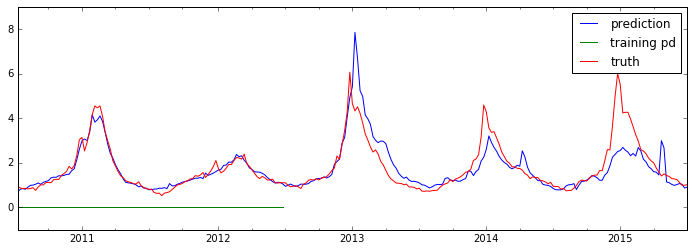

In [30]:
(m, s) = fit(sk.linear_model.ElasticNetCV(normalize=True, max_iter=1e5,
                                          positive=True, alphas=ALPHAS,
                                          l1_ratio=RHOS, tol=1e-3,
                                          selection='random', n_jobs=-1),
             104, ts_all, truth)
s.head(23)

### Elastic net, normalized, positive, auto 𝛼, manual 𝜌 = ½

* Forecast: good
* Articles: good

l1_ratio_                                    0.500000
alpha_                                       0.028730
intercept_                                  -0.245037
en+Influenzavirus_C                     826481.344753
en+Zanamivir                            160730.382584
en+Influenza_treatment                  108471.453477
en+Oseltamivir                           97324.411199
en+Influenzavirus_B                      90022.175851
en+Astrovirus                            59419.313914
en+Influenza_A_virus                     46625.143326
en+Human_respiratory_syncytial_virus     39743.360541
en+Upper_respiratory_tract_infection     36375.551003
en+Bronchiolitis                         34871.425854
en+Bacterial_pneumonia                   17316.317865
en+Influenza_A_virus_subtype_H1N1         6801.275141
en+Rotavirus                              6708.384087
en+Influenza                              5699.547016
en+Fever                                  5459.816037
en+Bronchitis               

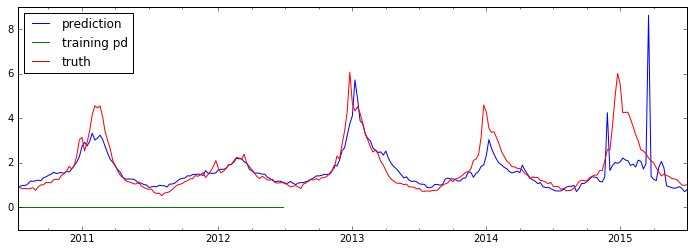

In [31]:
(m, s) = fit(sk.linear_model.ElasticNetCV(normalize=True, max_iter=1e5,
                                          positive=True, alphas=ALPHAS,
                                          l1_ratio=0.5,
                                          selection='random', n_jobs=-1),
             104, ts_all, truth)
s.head(23)

### Elastic net, normalized, unrestricted, auto 𝛼, auto 𝜌

* Forecast: good
* Articles: medium

l1_ratio_                                    0.900000
alpha_                                       0.005623
intercept_                                   0.337396
en+Influenzavirus_C                     381590.474341
en+Pneumomediastinum                   -378156.557094
en+Influenzavirus_B                     248227.999622
en+Oseltamivir                          218214.742882
en+Human_respiratory_syncytial_virus     87228.726543
en+Bronchiolitis                         81839.765311
en+BK_virus                             -51330.887063
en+Influenza_A_virus                     35261.133651
en+Influenza_treatment                   14603.198955
en+Croup                                  8994.528748
en+Sore_throat                            8624.922674
en+List_of_ICD-9_codes                   -6575.180127
en+Influenza                              1622.253033
en+Peramivir                                 0.000000
en+2009_flu_pandemic                        -0.000000
en+Influenza_A_virus_subtype

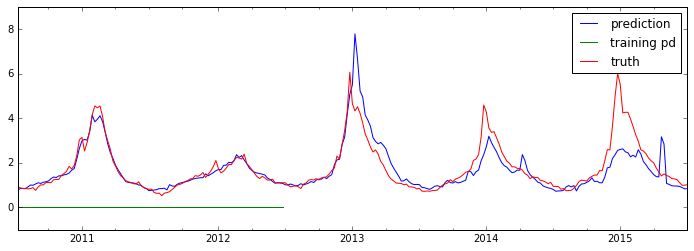

In [32]:
(m, s) = fit(sk.linear_model.ElasticNetCV(normalize=True, max_iter=1e5,
                                          alphas=ALPHAS, l1_ratio=RHOS,
                                          tol=1e-3, selection='random',
                                          n_jobs=-1),
             104, ts_all, truth)
s.head(23)

### Elastic net, normalized, unrestricted, auto 𝛼, manual 𝜌 = ½

* Forecast: good
* Articles: good?

l1_ratio_                                    0.500000
alpha_                                       0.028730
intercept_                                  -0.244807
en+Influenzavirus_C                     826978.407674
en+Zanamivir                            160022.005364
en+Influenza_treatment                  108563.565734
en+Oseltamivir                           97197.575611
en+Influenzavirus_B                      90005.985226
en+Astrovirus                            58350.797090
en+Influenza_A_virus                     46689.716216
en+Human_respiratory_syncytial_virus     39737.322136
en+Upper_respiratory_tract_infection     36390.850083
en+Bronchiolitis                         34905.529928
en+Bacterial_pneumonia                   17243.148077
en+Influenza_A_virus_subtype_H1N1         6807.046378
en+Rotavirus                              6731.666341
en+Influenza                              5697.784412
en+Fever                                  5469.369464
en+Bronchitis               

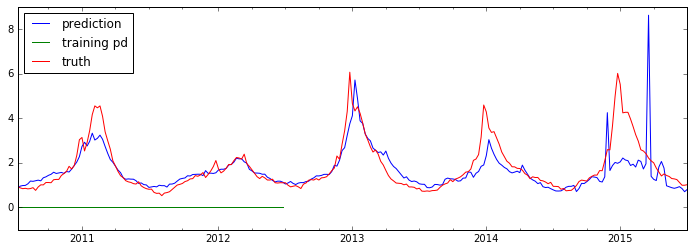

In [33]:
(m, s) = fit(sk.linear_model.ElasticNetCV(normalize=True, max_iter=1e5,
                                          alphas=ALPHAS, l1_ratio=0.5,
                                          tol=1e-3, selection='random',
                                          n_jobs=-1),
             104, ts_all, truth)
s.head(23)

### Elastic net, not normalized, positive, auto 𝛼, auto 𝜌

* Forecast: medium (noisy)
* Articles: bad?

l1_ratio_                                 5.000000e-01
alpha_                                    2.610157e-14
intercept_                               -2.700600e+00
en+Influenzavirus_B                       3.557183e+05
en+Oseltamivir                            1.692913e+05
en+Sore_throat                            1.150712e+05
en+2007_Bernard_Matthews_H5N1_outbreak    1.097603e+05
en+Influenza_treatment                    1.091778e+05
en+Human_respiratory_syncytial_virus      1.083595e+05
en+Ramsay_Hunt_syndrome_type_II           9.900899e+04
en+Mumps_virus                            6.783153e+04
en+Airborne_disease                       6.291818e+04
en+Wayback_Machine                        6.208304e+04
en+Bibcode                                5.414273e+04
en+Influenza_A_virus_subtype_H1N2         5.223943e+04
en+Adult_T-cell_leukemia/lymphoma         4.891966e+04
en+Pleural_empyema                        4.859992e+04
en+Influenza_A_virus_subtype_H5N1         4.361077e+04
en+Anal_ca

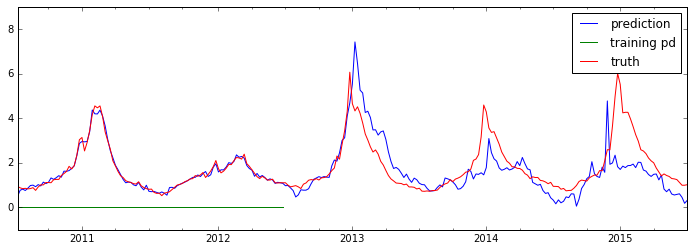

In [34]:
(m, s) = fit(sk.linear_model.ElasticNetCV(normalize=False, max_iter=1e5,
                                          positive=True, alphas=ALPHAS,
                                          l1_ratio=RHOS, tol=1e-3,
                                          selection='random', n_jobs=-1),
             104, ts_all, truth)
s.head(23)

### Elastic net, not normalized, positive, auto 𝛼, manual 𝜌 = ½

* Forecast: good
* Articles: bad?

l1_ratio_                                 5.000000e-01
alpha_                                    2.610157e-14
intercept_                               -2.700600e+00
en+Influenzavirus_B                       3.557183e+05
en+Oseltamivir                            1.692912e+05
en+Sore_throat                            1.150712e+05
en+2007_Bernard_Matthews_H5N1_outbreak    1.097602e+05
en+Influenza_treatment                    1.091777e+05
en+Human_respiratory_syncytial_virus      1.083595e+05
en+Ramsay_Hunt_syndrome_type_II           9.900897e+04
en+Mumps_virus                            6.783154e+04
en+Airborne_disease                       6.291818e+04
en+Wayback_Machine                        6.208303e+04
en+Bibcode                                5.414272e+04
en+Influenza_A_virus_subtype_H1N2         5.223942e+04
en+Adult_T-cell_leukemia/lymphoma         4.891967e+04
en+Pleural_empyema                        4.859992e+04
en+Influenza_A_virus_subtype_H5N1         4.361077e+04
en+Anal_ca

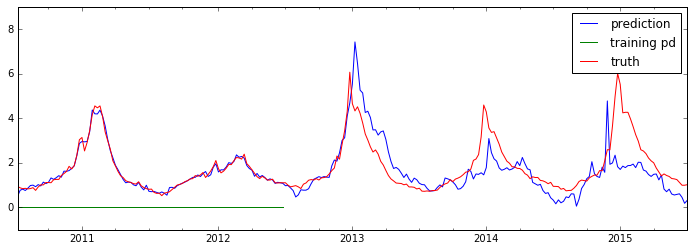

In [35]:
(m, s) = fit(sk.linear_model.ElasticNetCV(normalize=False, max_iter=1e5,
                                          positive=True, alphas=ALPHAS,
                                          l1_ratio=0.5, tol=1e-3,
                                          selection='random', n_jobs=-1),
             104, ts_all, truth)
s.head(23)

### Elastic net, not normalized, unrestricted, auto 𝛼, auto 𝜌

* Forecast: bad (flat)
* Articles: bad (none)

l1_ratio_                                          0.100000
alpha_                                           100.000000
intercept_                                         1.588952
en+Hemopneumothorax                                0.000000
en+Centers_for_Disease_Control_and_Prevention     -0.000000
en+Peramivir                                       0.000000
en+Influenza_A_virus_subtype_H1N1                  0.000000
en+Restrictive_lung_disease                        0.000000
en+Pathogenesis                                    0.000000
en+Pneumonitis                                     0.000000
en+Specialty_%28medicine%29                       -0.000000
en+Wendell_Meredith_Stanley                        0.000000
en+Frank_Macfarlane_Burnet                         0.000000
en+Hemagglutinin                                   0.000000
en+2009_flu_pandemic                               0.000000
en+Pneumomediastinum                               0.000000
en+Ghent_University                     

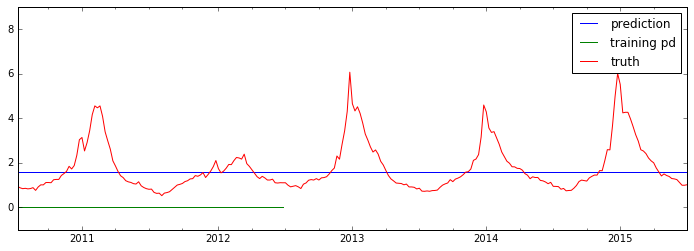

In [37]:
(m, s) = fit(sk.linear_model.ElasticNetCV(normalize=False, max_iter=2e5,
                                          alphas=ALPHAS, l1_ratio=RHOS,
                                          selection='random',
                                          tol=1e-3, n_jobs=-1),
             104, ts_all, truth)
s.head(23)

### Elastic net, not normalized, unrestricted, auto 𝛼, manual 𝜌 = ½

* Forecast: bad
* Articles: bad?

l1_ratio_                                  5.000000e-01
alpha_                                     5.108970e-15
intercept_                                 1.468754e+00
en+Human_respiratory_syncytial_virus       7.135622e+04
en+Influenza_A_virus                       6.900837e+04
en+Influenzavirus_B                        5.564424e+04
en+Influenza                               5.310869e+04
en+Diarrhea                               -4.661123e+04
en+Oseltamivir                             4.157463e+04
en+Pharyngitis                             3.646728e+04
en+History_of_Rome                         3.519844e+04
en+Herpes_simplex_virus                   -3.477527e+04
en+Fever                                   3.305496e+04
en+Influenza_A_virus_subtype_H3N2         -3.205144e+04
en+Biosafety_level                        -2.980827e+04
en+World_Health_Organization               2.882814e+04
en+Croup                                   2.788328e+04
en+Larynx                                  2.735

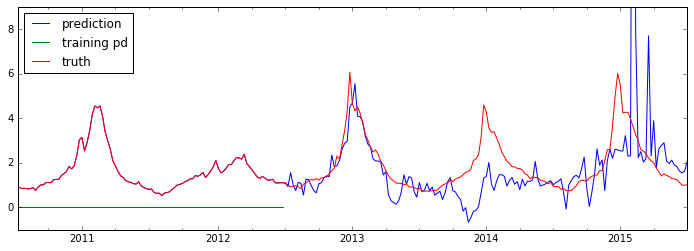

In [38]:
(m, s) = fit(sk.linear_model.ElasticNetCV(normalize=False, max_iter=1e5,
                                          alphas=ALPHAS, l1_ratio=0.5,
                                          selection='random',
                                          tol=1e-3, n_jobs=-1),
             104, ts_all, truth)
s.head(23)